## Overview
Develop a machine learning program to identify when an article might be fake news

## Load Libraries
Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data
Load the data into Training and Test variables

In [2]:
#Read training data
X = pd.read_csv("Fake_News_Classifer/train.csv")

#Test data
X_test = pd.read_csv("Fake_News_Classifer/test.csv")


# Clean Dataset
The Label column on the training set determines if an article is reliable or not.

**1 = unreliable 0 = reliable**

Remove rows with missing target value(label column) and separate target value from predictors.

In [3]:
#Check for NA values in label column
X = X.fillna(" ")
#Separate target from predictors
y = X.label
X.drop(["label"], axis = 1, inplace = True)

## Create Validation Set
Split the validation and training set to account for overfitting and underfitting.

In [4]:
#Split training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

## Establish Score Function
Create function to score the machine learning model based on mean square absolute error and accuracy. The score is based on a random forest regressor.

In [5]:
def get_score(X_train, X_valid, y_train, y_valid, n_estimators, n_metric):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return n_metric(y_valid, preds.round())

## Check Cardinality and Label Encoding
Check for the number of unique values in each column to determine how to manipulate categorical variables. Then use a label encoder to recieve numerical values to utilize in the machine learning algorithm.

In [6]:
#receive column names that are categorical
cardinality_check = [col_name for col_name in X_train.columns if
                        X_train[col_name].dtype == "object"]

#check for unique values
for i in cardinality_check:
    print(X_train[cardinality_check][i].nunique())

select_cols = cardinality_check
#print(select_cols)

#Prepare for Label Encoding
#Do not disrupt original data
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

#apply label encoder
label_encoder = LabelEncoder()
for col in select_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.fit_transform(X_valid[col])

14923
3502
15338


## Accuracy Score
Calculate the accuracy of the model. Estimators vary by increments of 50.

In [7]:
results_accuracy = {}
for i in range(1, 9):
    results_accuracy[50*i] = get_score(label_X_train, label_X_valid, y_train, y_valid, 50*i, metrics.accuracy_score)
print("accuracy: ", results_accuracy)

accuracy:  {50: 0.5836538461538462, 100: 0.5809615384615384, 150: 0.58, 200: 0.5817307692307693, 250: 0.5813461538461538, 300: 0.5809615384615384, 350: 0.5811538461538461, 400: 0.5798076923076924}


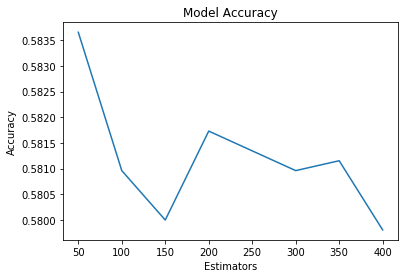

In [8]:
plt.plot(list(results_accuracy.keys()), list(results_accuracy.values()))
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

In [9]:
print("Best number of estimators: ", max(results_accuracy, key = results_accuracy.get))
print("Accuracy: ", results_accuracy[max(results_accuracy, key = results_accuracy.get)])

Best number of estimators:  50
Accuracy:  0.5836538461538462


## Confusion Matrix
Calculate the Confusion Matrix. Use the most accurate number of estimators (150).

In [10]:
results_matrix = {}

results_matrix = get_score(label_X_train, label_X_valid, y_train, y_valid, 150, confusion_matrix)
print("Confusion Matrix")
print(results_matrix)

Confusion Matrix
[[1391 1173]
 [1011 1625]]


## Classification Report
Return a summary of model accuracy using random forest classification.

In [11]:
results_report = get_score(label_X_train, label_X_valid, y_train, y_valid, 150, metrics.classification_report)
print(results_report)

              precision    recall  f1-score   support

           0       0.58      0.54      0.56      2564
           1       0.58      0.62      0.60      2636

    accuracy                           0.58      5200
   macro avg       0.58      0.58      0.58      5200
weighted avg       0.58      0.58      0.58      5200



## Cross Validation Test
Get the Cross Validation Score of the model using a different number of folds each time to break up the data. Use 150 estimators because the graphs above determined the number returned the most accurate results.

In [12]:
def score_cross_val(n_folds):
    model = RandomForestClassifier(n_estimators=150, random_state=0)
    cross = cross_val_score(model, label_X_train, y_train.round(), cv=n_folds, scoring="accuracy").mean()
    return cross

#print(cross)

In [13]:
results_cross = {}
for i in range(2, 9):
    results_cross[i] = score_cross_val(i)
print("Cross Validation Score: ", results_cross)

Cross Validation Score:  {2: 0.88314159078142, 3: 0.894038631429228, 4: 0.8983981720739203, 5: 0.8992959523865196, 6: 0.9021804684040292, 7: 0.9024367638180338, 8: 0.9038469032689642}


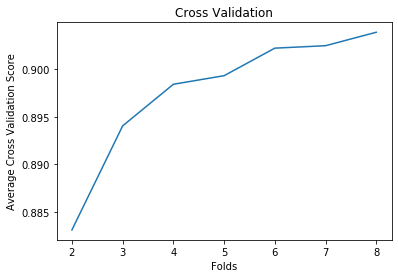

In [14]:
plt.plot(list(results_cross.keys()), list(results_cross.values()))
plt.xlabel('Folds')
plt.ylabel('Average Cross Validation Score')
plt.title('Cross Validation')
plt.show()

In [15]:
print("Best number of folds: ", max(results_cross, key = results_cross.get))
print("Mean Absolute eror: ", results_cross[max(results_cross, key = results_cross.get)])

Best number of folds:  8
Mean Absolute eror:  0.9038469032689642


## Test Data
Apply Machine Learning Model to test data

In [16]:
#preprocess test data
X_test = X_test.fillna(" ")
label_X_test = X_test.copy()
for col in select_cols:
    label_X_test[col] = label_encoder.fit_transform(X_test[col])
    
final_X_test = pd.DataFrame(label_X_test)

#get test predictions
model = RandomForestClassifier(n_estimators = 150, random_state = 1)
model.fit(label_X_train, y_train)
preds_test = model.predict(final_X_test)

In [17]:
#output predictions to dataframe
output = pd.DataFrame({'Id': X_test.index,
                       'label': preds_test.round()})
print(output)
output.to_csv('submission.csv', index=False)

        Id  label
0        0      1
1        1      1
2        2      1
3        3      0
4        4      0
...    ...    ...
5195  5195      1
5196  5196      0
5197  5197      0
5198  5198      1
5199  5199      1

[5200 rows x 2 columns]


In [28]:
def get_score_test(X_valid, y_train, y_valid, n_estimators, n_metric):
    model = RandomForestClassifier(n_estimators = n_estimators, random_state = 1)
    model.fit(label_X_train, y_train)
    preds_test = model.predict(final_X_test)
    return n_metric(y_valid, preds_test)

In [19]:
results_accuracy_test = {}
for i in range(1, 9):
    results_accuracy_test[50*i] = get_score_test(final_X_test, y_train, y_valid, 50*i, metrics.accuracy_score)
print("accuracy: ", results_accuracy_test)

accuracy:  {50: 0.4980769230769231, 100: 0.49788461538461537, 150: 0.49673076923076925, 200: 0.49538461538461537, 250: 0.49538461538461537, 300: 0.4973076923076923, 350: 0.4963461538461538, 400: 0.49653846153846154}


In [29]:
results_matrix_test = {}

results_matrix_test = get_score_test(final_X_test, y_train, y_valid, 150, confusion_matrix)
print("Confusion Matrix")
print(results_matrix_test)

Confusion Matrix
[[1122 1442]
 [1175 1461]]


In [34]:
results_testreport = get_score_test(final_X_test, y_train, y_valid, 150, metrics.classification_report)
print(results_testreport)

              precision    recall  f1-score   support

           0       0.49      0.44      0.46      2564
           1       0.50      0.55      0.53      2636

    accuracy                           0.50      5200
   macro avg       0.50      0.50      0.49      5200
weighted avg       0.50      0.50      0.50      5200



In [20]:
def score_cross_val_test(n_folds):
    model = RandomForestClassifier(n_estimators=150, random_state=2)
    cross = cross_val_score(model, final_X_test, y_valid, cv=n_folds, scoring="accuracy").mean()
    return cross

In [21]:
results_cross_test = {}
for i in range(2, 9):
    results_cross_test[i] = score_cross_val_test(i)
print("Cross Validation Score: ", results_cross_test)

Cross Validation Score:  {2: 0.5, 3: 0.509224556552685, 4: 0.504423076923077, 5: 0.4974972263287965, 6: 0.5084596268664658, 7: 0.5099866946022316, 8: 0.5047884728721251}


## Compare Training and Test Data
Compare the accuracy based on training data versus test data

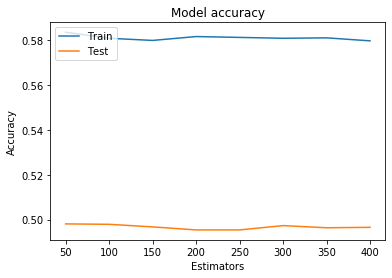

In [22]:
x_cords = list(results_accuracy.keys())
y1_cords = list(results_accuracy.values())
y2_cords = list(results_accuracy_test.values())
plt.plot(x_cords, y1_cords)
plt.plot(x_cords, y2_cords)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Estimators')
plt.legend(['Train', 'Test'], loc='upper left')